Hello, this is our Data Science Studio Final Project. Today, we will be performing an analysis and creating mutliple classification models using the DCWP Consumer Complaints Dataset. Consumer complaints are an important signal for identifying patterns of dissatisfaction, fraud, or misconduct among businesses. By analyzing consumer complaints, agencies and companies can improve cutomer service, ensure compliance with regulations, and protect consumers from unfair practices.

### The aim of this analysis

Today, we will assume the role of data analysts working for a consumer protection agency. We need to analyze the DCWP Consumer Complaints dataset and develop classification models that could accurately predict the status of a consumer complaint based on various factors such as the type of business, type of complaint, and subission methods. We will also evaluate the different models to see which one performs better. Some of the questions we aim to answer are:
- Which features are most import in determining the final status of a consumer complaint?
- Can we identify any patterns or trends in the types of complaints received across different business categories?
- Can we build a predictive model that can accurately classify the complaint status based on the available information?

### Introducing the Dataset

The dataset we will be using for this project is the DCWP Consumer Complaints Datset, which we retrieved from the NYC Open Data Portal using an API. The Department of Consumer and WOrker Protection (DCWP) records complaints filed by consumers against businesses operating in New York City. This dataset provides valuable insights into consumer issues and business compliance across various inductries.

The features we will be using in this project are:

Let's start by exploring the dataset!

In [91]:
# Importing necessary libraries

from sodapy import Socrata
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


In [92]:
# Creating a client object to make API requests

client = Socrata("data.cityofnewyork.us", None)

In [93]:
# The ID of the dataset

dataset_id = "nre2-6m2s"

In [94]:
# Getting the data

results = client.get(dataset_id, limit = 5000)

In [95]:
# Putting it into a dataframe

df = pd.DataFrame.from_records(results)

In [96]:
df.head()

,record_id,intake_date,intake_channel,_311_sr_number,business_category,complaint_code,business_unique_id,business_name,result_date,result,...,census_block_2010_,census_tract_2010_,latitude,longitude,street2,apt_suite,unit_type,refund_amount,street3,contract_cancelled_amount
0,057329-2025-CMPL,2025-02-24T00:00:00.000,311,311-22038149,Restaurant,Price Gouging,BA-1722078-2025,pateizia restaurant,2025-02-24T00:00:00.000,Referred,...,8002,66,40.73991700211976,-73.97939843013278,NaN,NaN,NaN,NaN,NaN,NaN
1,057324-2025-CMPL,2025-02-24T00:00:00.000,311,311-22036709,Supermarket,Overcharge,BA-1722116-2025,A & Y Embassy Food Corp.,2025-02-24T00:00:00.000,Referred,...,3005,539,40.707436555829005,-73.9154949964182,NaN,NaN,NaN,NaN,NaN,NaN
2,057319-2025-CMPL,2025-02-24T00:00:00.000,311,311-22036401,Misc Non-Food Retail,Non-Delivery of Goods - N01,BA-1722067-2025,BURGER KING,2025-02-24T00:00:00.000,Complaint Review Complete,...,1006,109,40.74997771919704,-73.98792375849172,NaN,NaN,NaN,NaN,NaN,NaN
3,057305-2025-CMPL,2025-02-23T00:00:00.000,311,311-22034563,Supermarket,Non-Delivery of Goods - N01,BA-1722054-2025,OCEAN BAY MARKET INC.,2025-02-24T00:00:00.000,Referred,...,1000,392,40.59765876127,-73.9611496265785,NaN,NaN,NaN,NaN,NaN,NaN
4,057273-2025-CMPL,2025-02-23T00:00:00.000,311,311-22025951,Dry Cleaners,Lost/Stolen/Damaged Property,BA-1722025-2025,Vital tailor shop,2025-02-24T00:00:00.000,Insufficient Info Received,...,2001,101,40.65667828908096,-74.00194621940757,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
# Checking the initial shape of the dataset

df.shape

(5000, 33)

In [98]:
# The columns

df.columns.tolist()

['record_id',
 'intake_date',
 'intake_channel',
 '_311_sr_number',
 'business_category',
 'complaint_code',
 'business_unique_id',
 'business_name',
 'result_date',
 'result',
 'referred_to',
 'address_type',
 'building_nbr',
 'street1',
 'city',
 'state',
 'postcode',
 'borough',
 'community_board',
 'council_district',
 'bin',
 'bbl',
 'nta',
 'census_block_2010_',
 'census_tract_2010_',
 'latitude',
 'longitude',
 'street2',
 'apt_suite',
 'unit_type',
 'refund_amount',
 'street3',
 'contract_cancelled_amount']

### Pre-processing the Data

Before building a classification model, it is important to preprocess the data in a careful matter to ensure it is clean, consistent, and suitable for the algorithms we will be using in this porject.

We will preprocess the data by handling missing values, dropping irrelevant features, simplifying the target variable, encode categorical variables, and doing feature engineering!

In [99]:
# Checking and sorting missing values
df.isnull().sum().sort_values(ascending = False)

contract_cancelled_amount    4998
street3                      4996
refund_amount                4931
street2                      4846
unit_type                    4795
apt_suite                    4595
referred_to                  2814
_311_sr_number               1427
bbl                           815
bin                           815
nta                           697
census_block_2010_            697
complaint_code                673
building_nbr                  643
census_tract_2010_            555
community_board               555
council_district              555
longitude                     509
latitude                      509
borough                       489
city                          191
business_unique_id            145
business_name                 144
state                          51
postcode                       50
street1                        50
address_type                   45
business_category               8
record_id                       0
result        

In [100]:
# Dropping irrelevant columns
# Feature Selection
columns_to_drop = [
    'record_id', '_311_sr_number', 'business_unique_id', 'building_nbr',
    'street1', 'street2', 'street3', 'apt_suite', 'bin', 'bbl', 'latitude', 'longitude',
    'borough', 'community_board', 'council_district', 'nta',
    'census_block_2010_', 'census_tract_2010_', 'address_type', 'state', 'postcode', 'referred_to', 'city'
]

df = df.drop(columns=columns_to_drop, errors='ignore')

# Checking new shape
# we can see that we have 10 columns after we drop the list
df.shape

(5000, 10)

In [101]:
# Checking for nulls after removing irrelevant features
df.isnull().sum().sort_values(ascending = False)

contract_cancelled_amount    4998
refund_amount                4931
unit_type                    4795
complaint_code                673
business_name                 144
business_category               8
intake_channel                  0
intake_date                     0
result_date                     0
result                          0
dtype: int64

In [102]:
# Dropping columns with 50% missing values by setting a threshold
threshold = len(df) * 0.5
df = df.dropna(thresh=threshold, axis=1)

# filling missing values for categorical columns with 'Unknown'
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

In [103]:
# final check for nulls
# we can see that we do not have missing values anymore 
df.isnull().sum()

intake_date          0
intake_channel       0
business_category    0
complaint_code       0
business_name        0
result_date          0
result               0
dtype: int64

In [104]:
# Feature engineering
# Creating the column resolution_days to see how many days the issue took to be resolved

df['intake_date'] = pd.to_datetime(df['intake_date'], errors = 'coerce')
df['result_date'] = pd.to_datetime(df['result_date'], errors = 'coerce')

df['resolution_days'] = (df['result_date']-df['intake_date']).dt.days

In [105]:
# Simplifying the target class variable to improve model performance
# this helps balance the dataset and avoid overfitting to very small classes

positive_responses = ['Resolved', 'Reduced', 'Goods', 'Store Credit', 'Cash Amount', 'Took Action', 'Consumer Restitution']

df['vendor_responded'] = df['result'].apply(lambda x: 1 if any(keyword.lower() in x.lower() for keyword in positive_responses) else 0)

In [106]:
# Initializing both Label Encoders

le_business_category = LabelEncoder()
le_complaint_code = LabelEncoder()

# Applying Label Encoding to categorical columns needed

df['business_category_encoded'] = le_business_category.fit_transform(df['business_category'].astype(str))
df['complaint_code_encoded'] = le_complaint_code.fit_transform(df['complaint_code'].astype(str))

In [107]:
# Creating a list of the features we want to use
features = ['business_category_encoded', 'complaint_code_encoded', 'resolution_days']

# Defining the features (X) and the target variable (y)

X = df[features]
y = df['vendor_responded']

In [108]:
# Splitting the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y) 

# checking the sizes of both the training and testing data
# same amount of columns
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (4000, 3)
Testing set size: (1000, 3)


In [109]:
# Creating a Random Forest Classifier

rf_model = RandomForestClassifier(random_state = 42) # Initializing
rf_model.fit(X_train, y_train) # Training

y_pred_rf = rf_model.predict(X_test) # Making predictions

# Evaluating the model

print("Random Forest Classifier Results:")
print("----------------------------------")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred_rf))

Random Forest Classifier Results:
----------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       976
           1       0.31      0.17      0.22        24

    accuracy                           0.97      1000
   macro avg       0.64      0.58      0.60      1000
weighted avg       0.96      0.97      0.97      1000

Confusion Matrix:
 [[967   9]
 [ 20   4]]

Accuracy Score: 0.971


In [110]:
# Creating a Logistic Regression model

logreg_model = LogisticRegression(max_iter=1000, random_state=42) # Initializing
logreg_model.fit(X_train, y_train) # Training

y_pred_logreg = logreg_model.predict(X_test) # Making predictions

# Evaluating the model

print("\nLogistic Regression Results:")
print("-----------------------------")
print(classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred_logreg))



Logistic Regression Results:
-----------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       976
           1       1.00      0.04      0.08        24

    accuracy                           0.98      1000
   macro avg       0.99      0.52      0.53      1000
weighted avg       0.98      0.98      0.97      1000

Confusion Matrix:
 [[976   0]
 [ 23   1]]

Accuracy Score: 0.977


In [111]:
# Creating a XGBoost model

xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42) # Initializing
xgb_model.fit(X_train, y_train) # Training

y_pred_xgb = xgb_model.predict(X_test) # Making predictions

# Evaluating the model

print("\nXGBoost Classifier Results:")
print("----------------------------")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred_xgb))



XGBoost Classifier Results:
----------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       976
           1       0.38      0.38      0.38        24

    accuracy                           0.97      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.97      0.97      0.97      1000

Confusion Matrix:
 [[961  15]
 [ 15   9]]

Accuracy Score: 0.97


In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve
import numpy as np

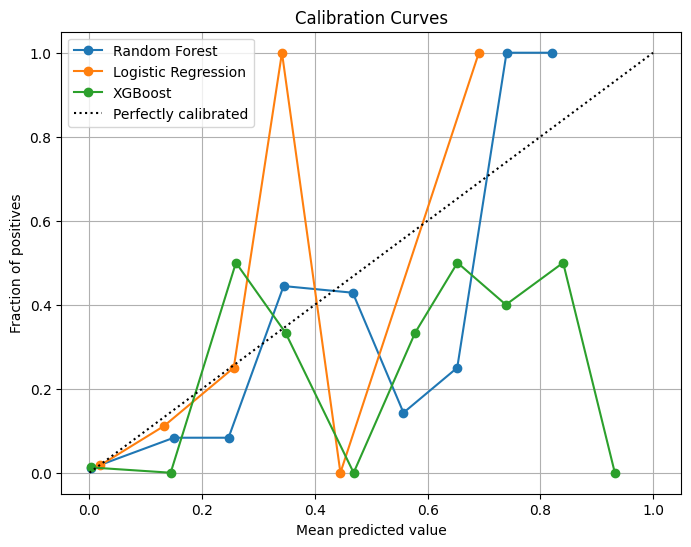

In [113]:
def plot_calibration_curve(model, name):
    prob_pos = model.predict_proba(X_test)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=name)

plt.figure(figsize=(8, 6))

plot_calibration_curve(rf_model, 'Random Forest')
plot_calibration_curve(logreg_model, 'Logistic Regression')
plot_calibration_curve(xgb_model, 'XGBoost')

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves')
plt.legend()
plt.grid()
plt.show()

X-axis (Mean predicted value):
- The average predicted probability output by the model.
- For example, when the model says "I'm 70% sure the vendor will respond," that's 0.7 on the x-axis.

Y-axis (Fraction of positives):
- The actual observed fraction where the vendor really did respond.
- If a group of predictions around 0.7 actually led to a 70% real response rate, the model is well-calibrated.

The calibration curve shows how well the predicted probabilities from our models match the actual outcomes for whether a vendor responded to a complaint. The Random Forest is the best-calibrated model, with its predicted probabilities reasonably close to the true probabilities, especially between 40–70%. Logistic Regression performs poorly, with highly unstable and erratic predictions that do not align well with real outcomes, making it unreliable for probability-based decision-making. XGBoost tends to consistently underestimate the probability of a vendor response, indicating underconfidence. Overall, while Random Forest can be trusted for reasonably accurate probability estimates, Logistic Regression and XGBoost would require additional calibration techniques like Platt scaling or Isotonic Regression if precise probability thresholds were needed for operational decisions.

C:\Users\kotha\AppData\Local\Temp\ipykernel_39204\2018124701.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='viridis')


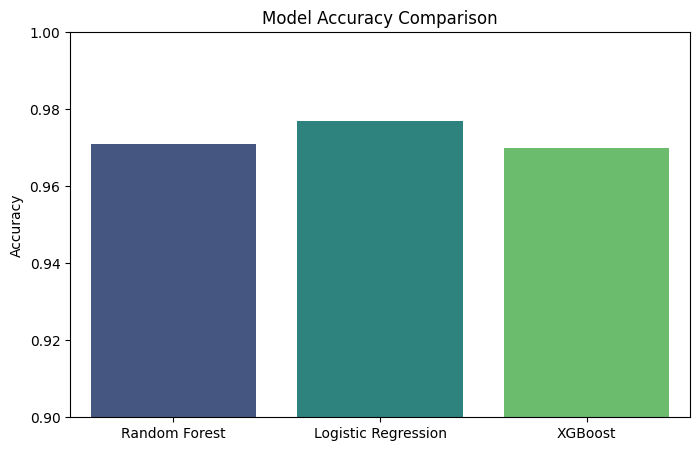

In [114]:
# Model Comparison Chart
model_names = ['Random Forest', 'Logistic Regression', 'XGBoost']
accuracies = [
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_logreg),
    accuracy_score(y_test, y_pred_xgb)
]

plt.figure(figsize=(8,5))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1)
plt.show()

The model accuracy comparison chart shows that all three models — Random Forest, Logistic Regression, and XGBoost — perform very well, achieving accuracy scores between 97% and 98% on the test data. Logistic Regression slightly outperforms the others, achieving the highest accuracy overall, followed closely by Random Forest and then XGBoost. While the differences in accuracy are relatively small, this suggests that Logistic Regression is best at correctly predicting whether a vendor responded to a complaint in this dataset. However, considering the earlier calibration analysis, despite its high accuracy, Logistic Regression's probability estimates are less reliable, meaning that Random Forest might still be a better choice if calibrated probability outputs are important for decision-making.

C:\Users\kotha\AppData\Local\Temp\ipykernel_39204\4034588117.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='coolwarm')


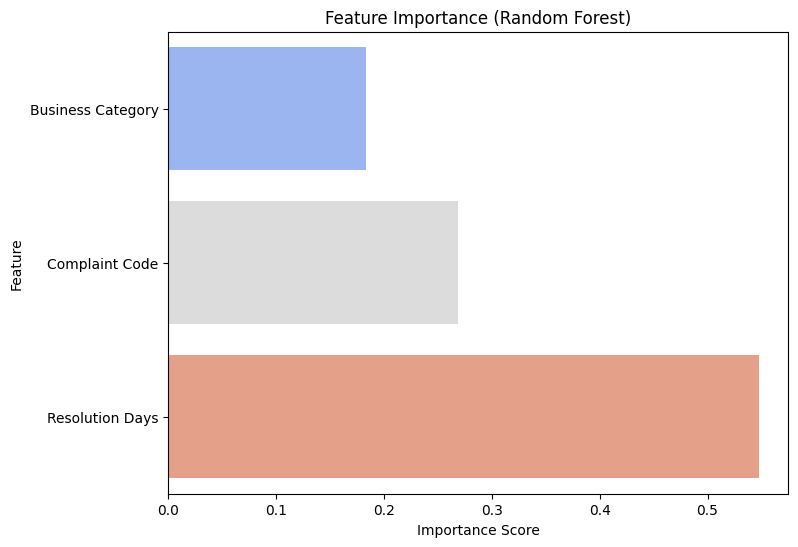

In [115]:
# Feature importance from the Random Forest model
importances = rf_model.feature_importances_
feature_names = ['Business Category', 'Complaint Code', 'Resolution Days']

plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=feature_names, palette='coolwarm')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

The feature importance plot from the Random Forest model highlights that "Resolution Days" is by far the most influential predictor in determining whether a vendor responded to a consumer complaint, with an importance score over 0.5. This suggests that the amount of time taken to resolve a complaint plays a crucial role in the outcome. "Complaint Code" is the second most important feature, meaning the type of complaint also strongly impacts whether a response is received. In contrast, "Business Category" has the least influence among the three features, though it still provides some predictive value. Overall, time to resolution emerges as the key driver in predicting vendor responses in NYC consumer complaints.

C:\Users\kotha\AppData\Local\Temp\ipykernel_39204\511909819.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_complaints.values, y=top_complaints.index, palette='coolwarm')


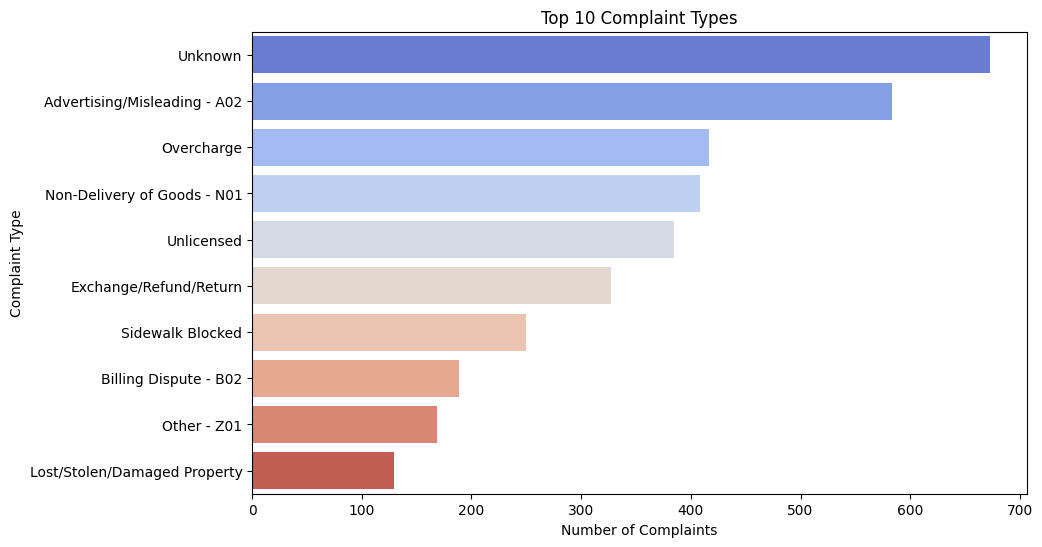

In [116]:
# Top Complaint Types
top_complaints = df['complaint_code'].value_counts().nlargest(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_complaints.values, y=top_complaints.index, palette='coolwarm')
plt.title('Top 10 Complaint Types')
plt.xlabel('Number of Complaints')
plt.ylabel('Complaint Type')
plt.show()

C:\Users\kotha\AppData\Local\Temp\ipykernel_39204\658660248.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='vendor_responded', order=df['vendor_responded'].value_counts().index, palette='viridis')


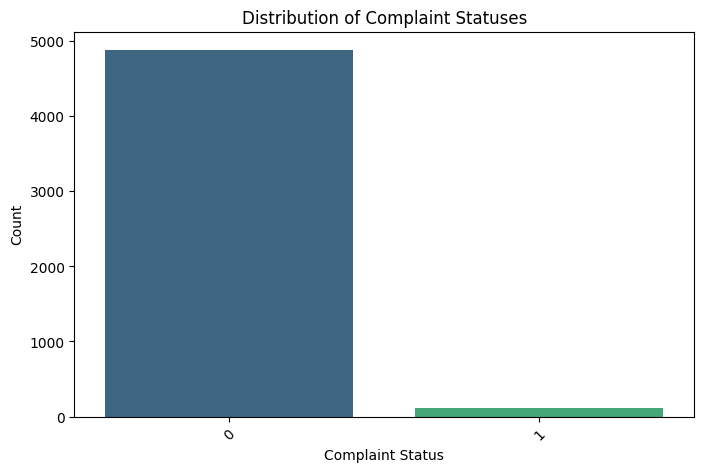

In [117]:
# Plot complaint status counts
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='vendor_responded', order=df['vendor_responded'].value_counts().index, palette='viridis')
plt.title('Distribution of Complaint Statuses')
plt.xlabel('Complaint Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

The graph shows the distribution of vendor responses to consumer complaints in New York City. Specifically, it illustrates the frequency of the binary target variable vendor_responded, where 0 indicates that the vendor did not respond positively to a complaint, and 1 indicates that the vendor provided a positive resolution, such as a refund, store credit, or taking corrective action. The visualization reveals a major imbalance in the dataset: the overwhelming majority of complaints fall into the 0 category, meaning that most vendors did not provide a satisfactory response. Only a very small portion of complaints resulted in a positive outcome.

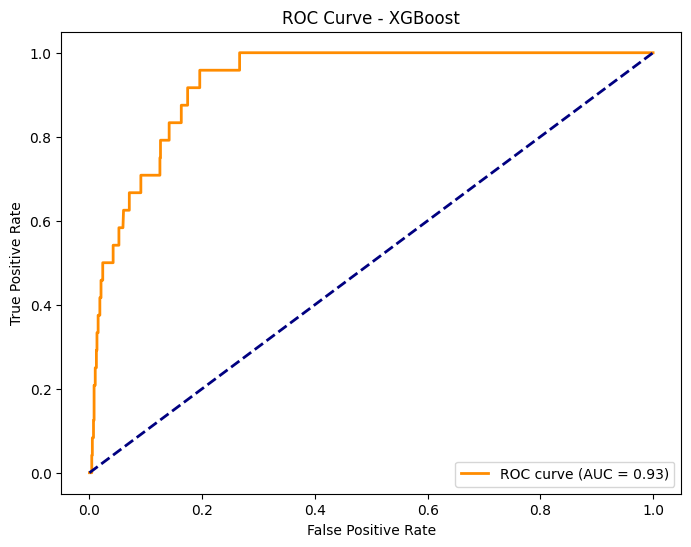

In [118]:
# Get probabilities for the positive class (1)
y_prob = xgb_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()

The ROC curve for the XGBoost model shows strong classification performance, with an Area Under the Curve (AUC) score of 0.93 showing that the model is highly effective at predicting whether a vendor complaint will be resolved or remain unresolved. The curve rises sharply toward the top-left corner, indicating that the model achieves a high true positive rate while maintaining a low false positive rate. An AUC of 0.93 suggests excellent separability between classes, meaning the model is very effective at distinguishing between vendors who responded to consumer complaints and those who did not. This means we can confidently use the model to prioritize and flag complaints that are less likely to be addressed quickly, helping the team intervene earlier and improve overall vendor responsiveness.

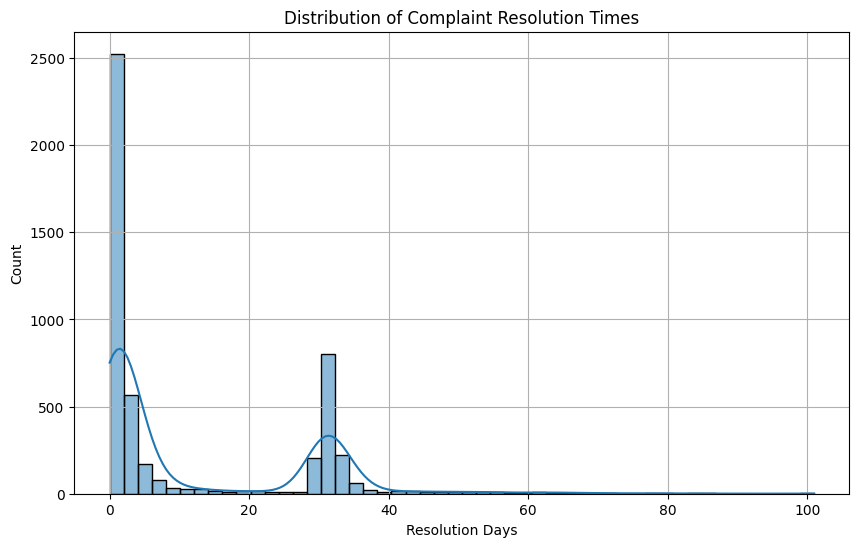

In [119]:
plt.figure(figsize=(10,6))
sns.histplot(df['resolution_days'].dropna(), bins=50, kde=True)
plt.xlabel('Resolution Days')
plt.title('Distribution of Complaint Resolution Times')
plt.grid()
plt.show()

The distribution of complaint resolution times shows that most vendor complaints are resolved very quickly, often within just a few days, while a smaller group takes significantly longer, with noticeable peaks around 30 days. This highlights that although the majority of vendors are responsive, there is a consistent subset that requires longer intervention periods. Understanding this pattern helps us predict which complaints are at risk of delayed resolution and allows us to focus resources more strategically to reduce overall complaint handling time.

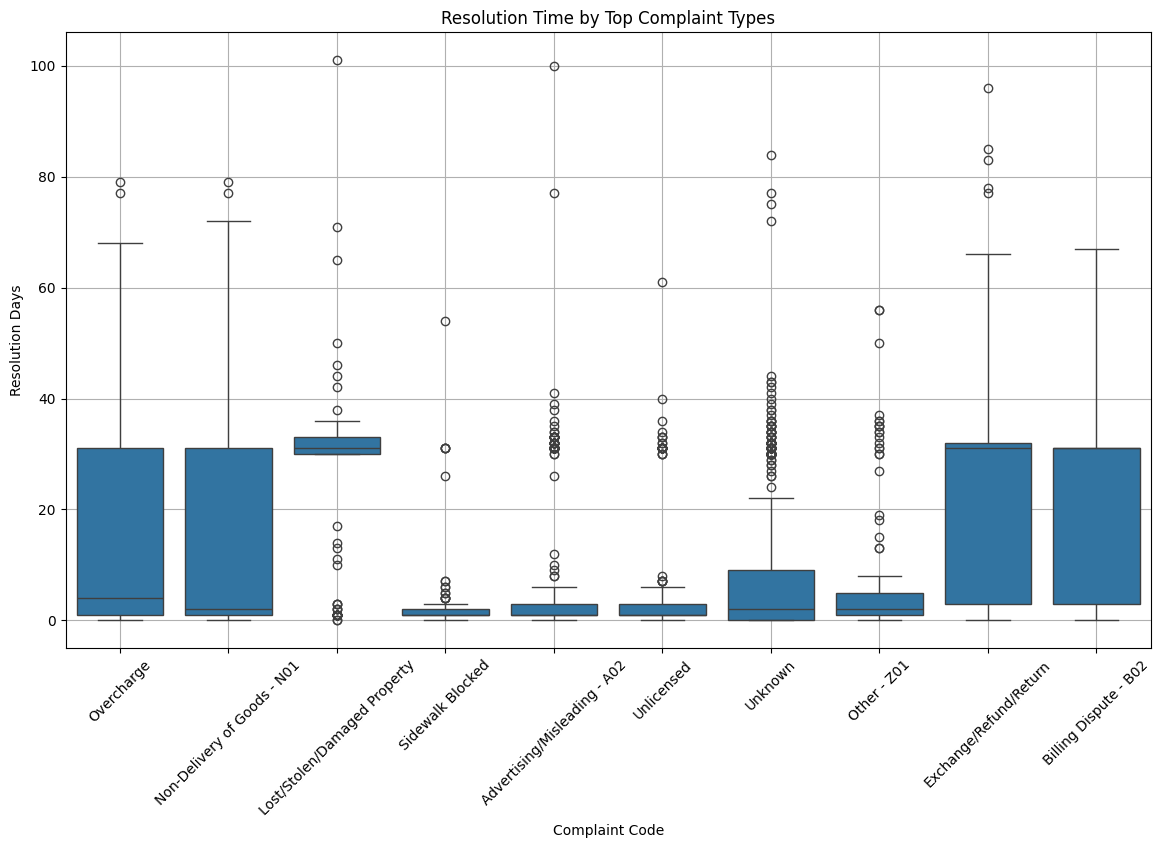

In [120]:
plt.figure(figsize=(14,8))
top_10_types = df['complaint_code'].value_counts().head(10).index
sns.boxplot(data=df[df['complaint_code'].isin(top_10_types)], 
            x='complaint_code', 
            y='resolution_days')
plt.xticks(rotation=45)
plt.xlabel('Complaint Code')
plt.ylabel('Resolution Days')
plt.title('Resolution Time by Top Complaint Types')
plt.grid()
plt.show()

The box plot of resolution times by complaint type shows that "Overcharge" and "Non-Delivery of Goods" complaints tend to have the widest range and longest resolution periods, often taking over 30 days to resolve, while issues like "Sidewalk Blocked" and "Advertising/Misleading" are usually addressed much faster. This suggests that these certain specific complaint categories inherently require more vendor interaction and follow-up, making them key targets for intervention strategies aimed at improving resolution speed.

C:\Users\kotha\AppData\Local\Temp\ipykernel_39204\1257395538.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=predict_df.sort_values('speed_prob', ascending=False), x='speed_prob', y='complaint_label', palette="viridis")


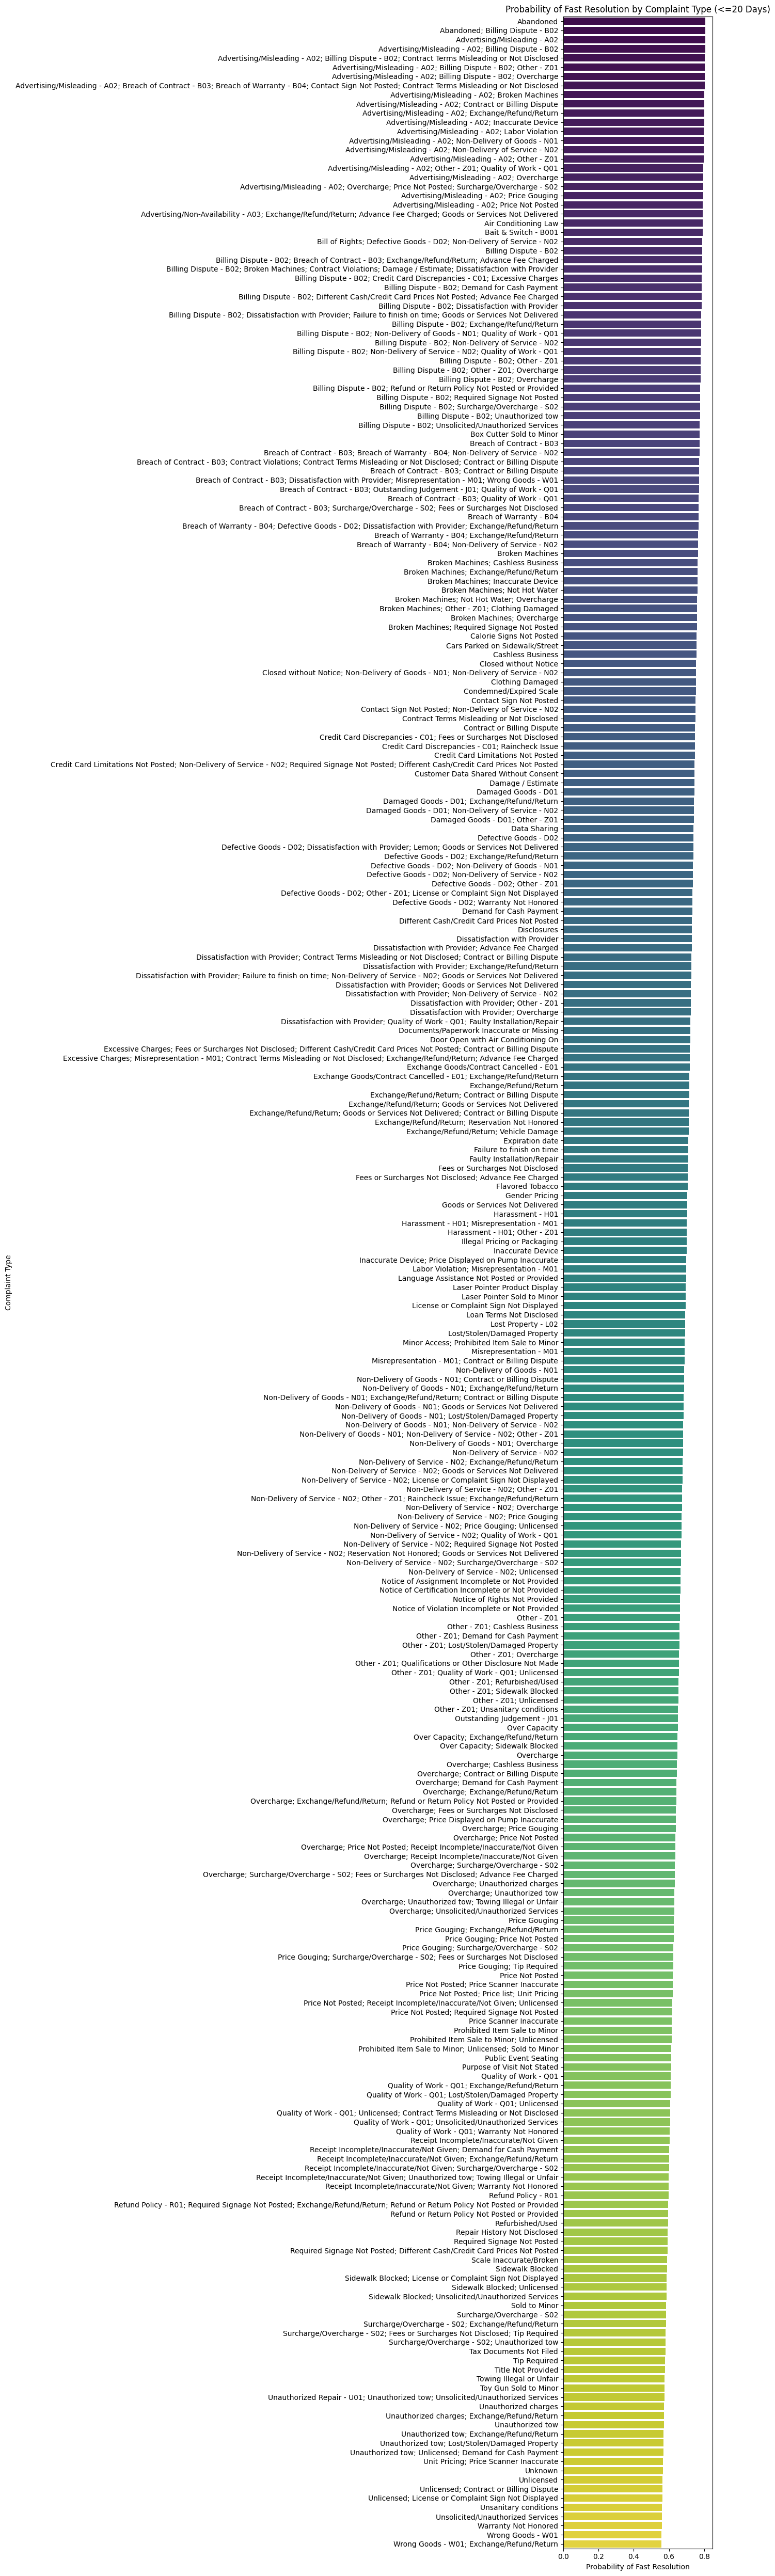

In [138]:
# 1. Create a new binary target for "speed" - resolved within 20 days
df['fast_resolution'] = (df['resolution_days'] <= 20).astype(int)

# 2. Model for fast resolutions
X_simple = df[['business_category_encoded', 'complaint_code_encoded', 'resolution_days']]
y_speed = df['fast_resolution']

speed_model = LogisticRegression(max_iter=1000, random_state=42)
speed_model.fit(X_simple, y_speed)

# 3. Predict probabilities for all complaint types
complaint_codes = np.sort(df['complaint_code_encoded'].unique())
predict_df = pd.DataFrame({
    'business_category_encoded': np.zeros_like(complaint_codes),  # neutral dummy
    'complaint_code_encoded': complaint_codes,
    'resolution_days': np.full_like(complaint_codes, 20)  # simulate 20 days
})

speed_probs = speed_model.predict_proba(predict_df[['business_category_encoded', 'complaint_code_encoded', 'resolution_days']])[:, 1]

# Decode complaint codes
predict_df['complaint_label'] = le_complaint_code.inverse_transform(predict_df['complaint_code_encoded'])
predict_df['speed_prob'] = speed_probs

# Plot: Fast resolution by complaint type
plt.figure(figsize=(14,50))
sns.barplot(data=predict_df.sort_values('speed_prob', ascending=False), x='speed_prob', y='complaint_label', palette="viridis")
plt.title("Probability of Fast Resolution by Complaint Type (<=20 Days)")
plt.xlabel("Probability of Fast Resolution")
plt.ylabel("Complaint Type")
plt.tight_layout()
plt.show()

C:\Users\kotha\AppData\Local\Temp\ipykernel_39204\2190819633.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_businesses, x='outcome_prob', y='business_label', palette="rocket")


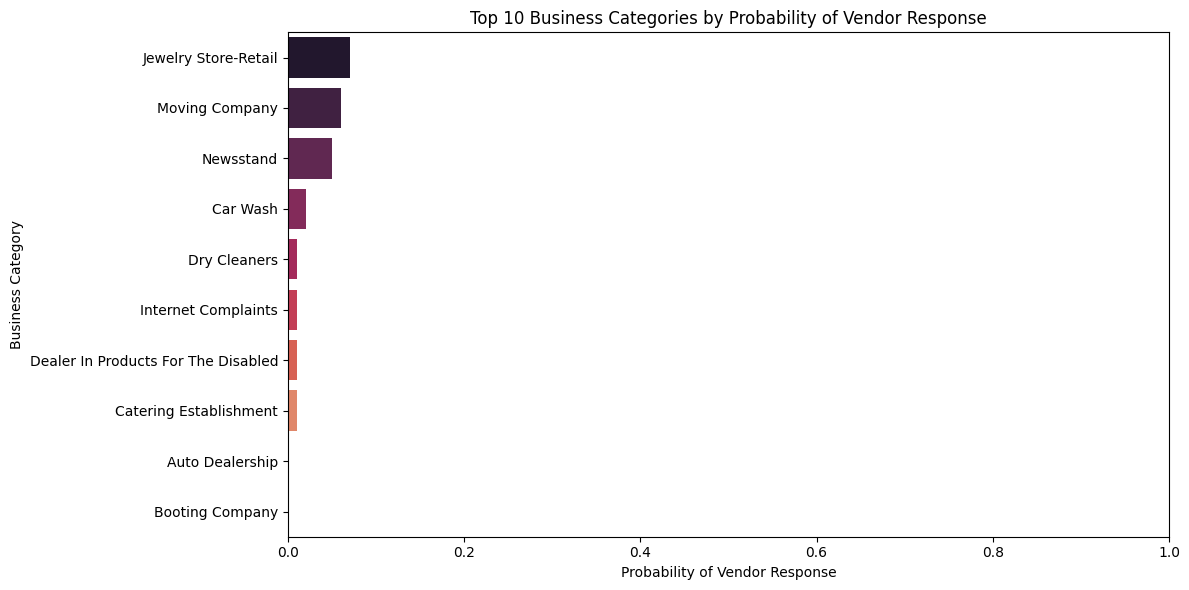

In [ ]:
business_cats = np.sort(df['business_category_encoded'].unique())
predict_business_df = pd.DataFrame({
    'business_category_encoded': business_cats,
    'complaint_code_encoded': np.zeros_like(business_cats),  # neutral dummy
    'resolution_days': np.full_like(business_cats, df['resolution_days'].median())  # median days
})

outcome_probs = rf_model.predict_proba(predict_business_df[['business_category_encoded', 'complaint_code_encoded', 'resolution_days']])[:, 1]

predict_business_df['business_label'] = le_business_category.inverse_transform(predict_business_df['business_category_encoded'])
predict_business_df['outcome_prob'] = outcome_probs

# Sort and pick Top 10 business categories
top10_businesses = predict_business_df.sort_values('outcome_prob', ascending=False).head(10)

# Plot: Vendor response probability by Top 10 Business Categories
plt.figure(figsize=(12,6))
sns.barplot(data=top10_businesses, x='outcome_prob', y='business_label', palette="rocket")
plt.title("Top 10 Business Categories by Probability of Vendor Response")
plt.xlabel("Probability of Vendor Response")
plt.ylabel("Business Category")
plt.xlim(0, 1)  # Probability range
plt.tight_layout()
plt.show()

C:\Users\kotha\AppData\Local\Temp\ipykernel_39204\3703295583.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_complaints, x='outcome_prob', y='complaint_label', palette="rocket")


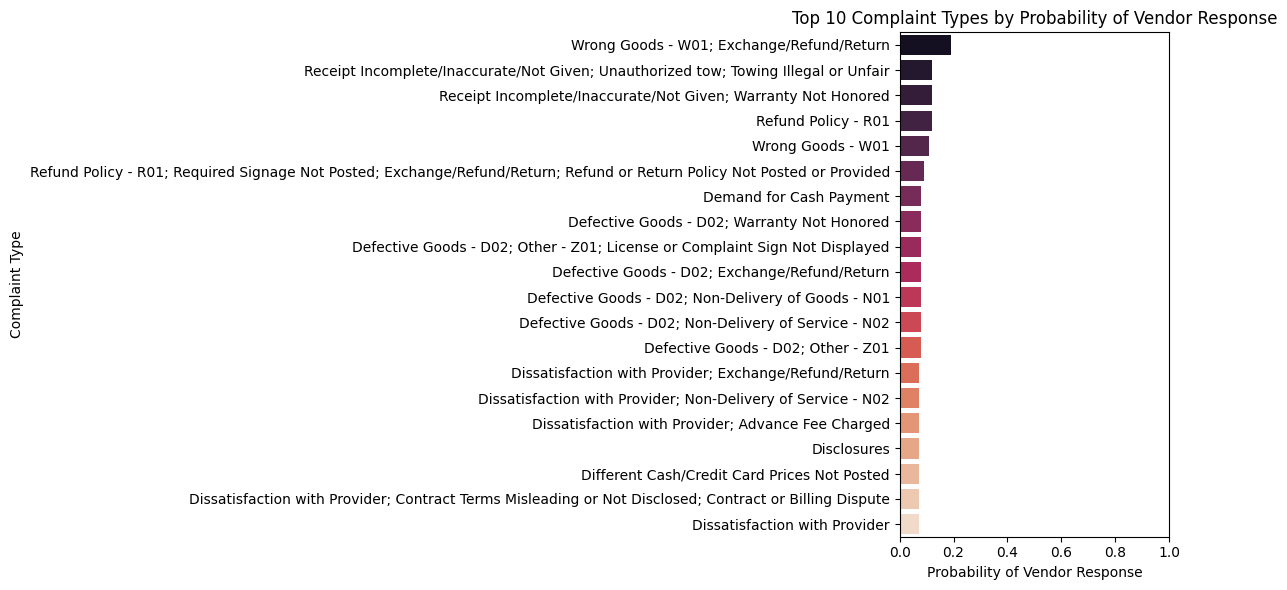

In [ ]:
complaint_codes = np.sort(df['complaint_code_encoded'].unique())
predict_complaint_df = pd.DataFrame({
    'business_category_encoded': np.zeros_like(complaint_codes),  # neutral dummy
    'complaint_code_encoded': complaint_codes,
    'resolution_days': np.full_like(complaint_codes, df['resolution_days'].median())  # median days
})

outcome_probs_complaint = rf_model.predict_proba(predict_complaint_df[['business_category_encoded', 'complaint_code_encoded', 'resolution_days']])[:, 1]

predict_complaint_df['complaint_label'] = le_complaint_code.inverse_transform(predict_complaint_df['complaint_code_encoded'])
predict_complaint_df['outcome_prob'] = outcome_probs_complaint

# Sort and pick Top 20 complaint types
top10_complaints = predict_complaint_df.sort_values('outcome_prob', ascending=False).head(20)

# Plot: Vendor response probability by Top 10 Complaint Types
plt.figure(figsize=(12,6))
sns.barplot(data=top10_complaints, x='outcome_prob', y='complaint_label', palette="rocket")
plt.title("Top 10 Complaint Types by Probability of Vendor Response")
plt.xlabel("Probability of Vendor Response")
plt.ylabel("Complaint Type")
plt.xlim(0, 1)  # Probability range
plt.tight_layout()
plt.show()

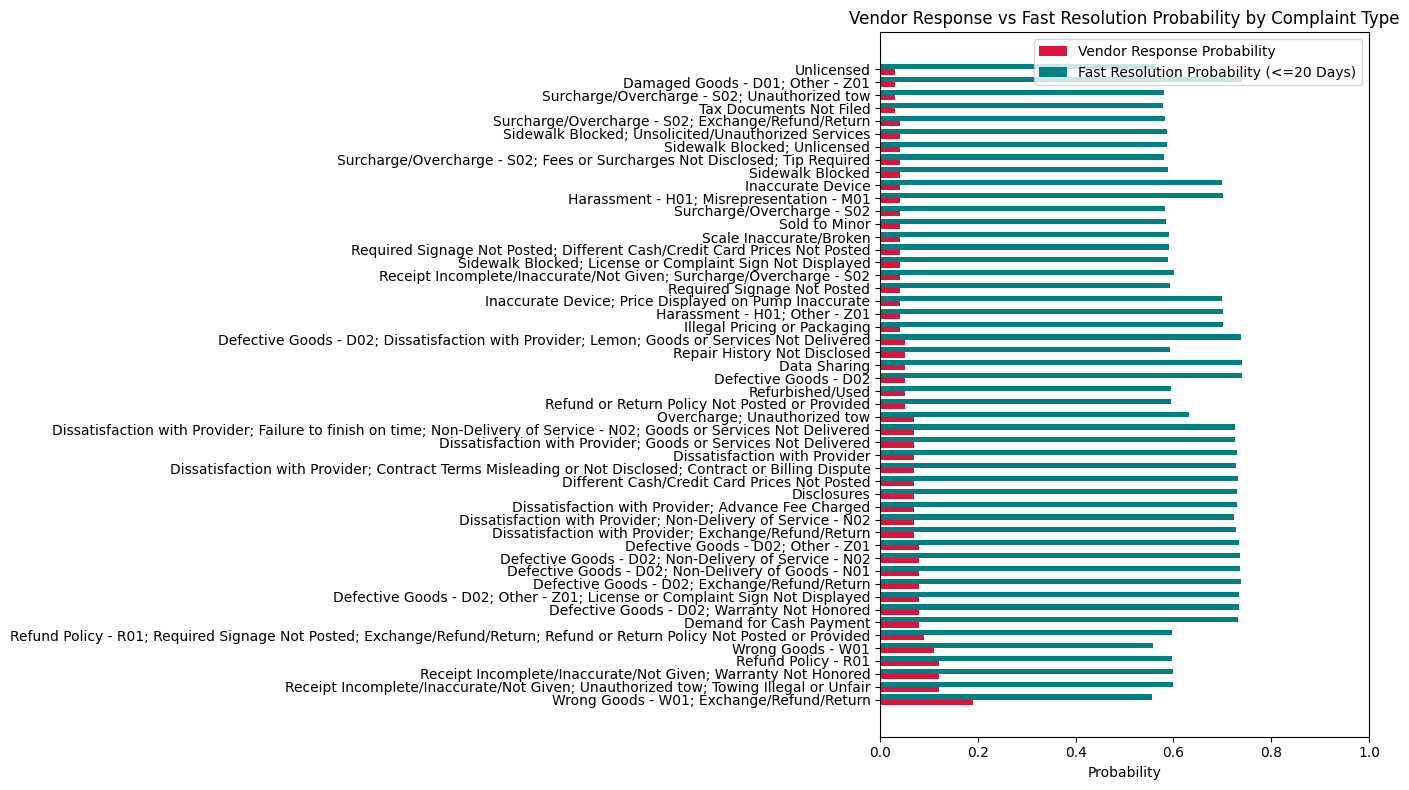

In [ ]:
# 1. Predict Vendor Response Probabilities for Complaint Types

complaint_codes = np.sort(df['complaint_code_encoded'].unique())

predict_complaint_df = pd.DataFrame({
    'business_category_encoded': np.zeros_like(complaint_codes),  # neutral dummy
    'complaint_code_encoded': complaint_codes,
    'resolution_days': np.full_like(complaint_codes, df['resolution_days'].median())  # median days
})

outcome_probs_complaint = rf_model.predict_proba(predict_complaint_df[['business_category_encoded', 'complaint_code_encoded', 'resolution_days']])[:, 1]

predict_complaint_df['complaint_label'] = le_complaint_code.inverse_transform(predict_complaint_df['complaint_code_encoded'])
predict_complaint_df['outcome_prob_vendor'] = outcome_probs_complaint

# 2. Predict Fast Resolution Probabilities for Complaint Types

predict_speed_df = pd.DataFrame({
    'business_category_encoded': np.zeros_like(complaint_codes),
    'complaint_code_encoded': complaint_codes,
    'resolution_days': np.full_like(complaint_codes, 20)  # simulate 20 days
})

speed_probs = speed_model.predict_proba(predict_speed_df[['business_category_encoded', 'complaint_code_encoded', 'resolution_days']])[:, 1]

predict_complaint_df['speed_prob'] = speed_probs

# 3. Select Top 10 Complaint Types by Vendor Response (optional filter for clarity)
top10_combined = predict_complaint_df.sort_values('outcome_prob_vendor', ascending=False).head(50)

# 4. Plot Combined
plt.figure(figsize=(14, 8))
bar_width = 0.4
indices = np.arange(len(top10_combined))

# Vendor Response Bars
plt.barh(indices, top10_combined['outcome_prob_vendor'], height=bar_width, label='Vendor Response Probability', color='crimson')

# Fast Resolution Bars (slightly shifted for visibility)
plt.barh(indices + bar_width, top10_combined['speed_prob'], height=bar_width, label='Fast Resolution Probability (<=20 Days)', color='teal')

# Labels and Title
plt.yticks(indices + bar_width/2, top10_combined['complaint_label'])
plt.xlabel("Probability")
plt.title("Vendor Response vs Fast Resolution Probability by Complaint Type")
plt.xlim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()